In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

import os

Mounted at /content/gdrive


In [2]:
data_dir = '/content/gdrive/Shareddrives/ComED Codes and Data/Dataset/Images/'

print(os.listdir(data_dir))

['With UPC', 'Without UPC']


In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import matplotlib.pyplot as plt


In [4]:
image_size = (600, 600)
batch_size = 32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/gdrive/Shareddrives/ComED Codes and Data/Dataset/Images",
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/gdrive/Shareddrives/ComED Codes and Data/Dataset/Images",
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)


Found 1024 files belonging to 2 classes.
Using 820 files for training.
Found 1024 files belonging to 2 classes.
Using 204 files for validation.


In [5]:
data_augmentation = keras.Sequential(
    [
        # layers.experimental.preprocessing.RandomFlip("horizontal"),
        # layers.experimental.preprocessing.RandomRotation(0.1),
        layers.experimental.preprocessing.Resizing(128,128)
    ]
)


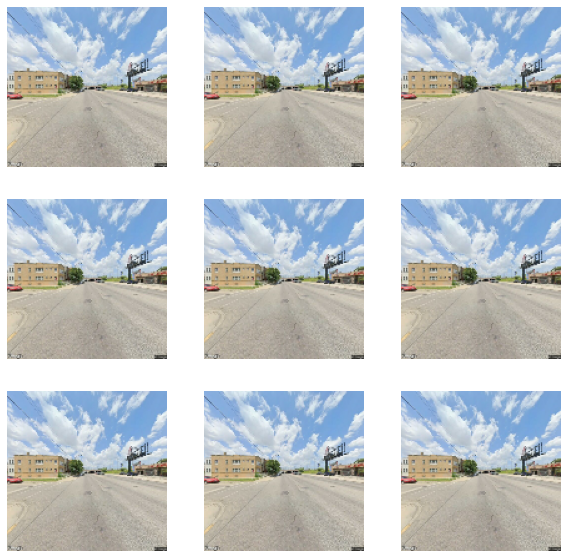

In [6]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")


In [7]:
train_ds = train_ds.prefetch(buffer_size=32)
val_ds = val_ds.prefetch(buffer_size=32)


In [8]:

def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    # Image augmentation block
    x = data_augmentation(inputs)

    # Entry block
    x = layers.experimental.preprocessing.Rescaling(1.0 / 255)(x)
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [128, 256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=2)
# keras.utils.plot_model(model, show_shapes=True)


In [9]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [10]:
epochs = 5

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5"),
]
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy",f1_m,precision_m, recall_m],
)
model.fit(
    train_ds, epochs=epochs, callbacks=callbacks, validation_data=val_ds
)


Epoch 1/5
26/26 [==============================] - 328s 12s/step - loss: 0.6211 - accuracy: 0.6690 - f1_m: 0.7746 - precision_m: 0.7449 - recall_m: 0.8202 - val_loss: 0.6656 - val_accuracy: 0.7598 - val_f1_m: 0.8483 - val_precision_m: 0.7440 - val_recall_m: 1.0000
Epoch 2/5
26/26 [==============================] - 10s 310ms/step - loss: 0.5504 - accuracy: 0.7468 - f1_m: 0.8191 - precision_m: 0.8168 - recall_m: 0.8289 - val_loss: 0.6432 - val_accuracy: 0.7598 - val_f1_m: 0.8665 - val_precision_m: 0.7664 - val_recall_m: 1.0000
Epoch 3/5
26/26 [==============================] - 10s 315ms/step - loss: 0.4515 - accuracy: 0.7639 - f1_m: 0.8367 - precision_m: 0.8119 - recall_m: 0.8765 - val_loss: 0.6159 - val_accuracy: 0.7598 - val_f1_m: 0.8669 - val_precision_m: 0.7664 - val_recall_m: 1.0000
Epoch 4/5
26/26 [==============================] - 10s 316ms/step - loss: 0.4066 - accuracy: 0.8230 - f1_m: 0.8774 - precision_m: 0.8347 - recall_m: 0.9460 - val_loss: 0.5969 - val_accuracy: 0.7598 - val